<font size="6">**Halo Density Profiles Analysis**</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, profile_einasto, mass_so, concentration

In [2]:
plt.rcParams['font.family'] =['Times New Roman']

In [3]:
# Load required data from Notebook 1
print("Loading data from Notebook 1...")
try:
    # Load saved data
    group_ids = np.load("group_ids.npy")
    group_size_distribution = np.load("group_size_distribution.npy", allow_pickle=True).item()
    
    # Load coordinates if available, otherwise need to reload
    # Note: You may need to re-run the coordinate loading from notebook 1 if not saved
    print("✓ Group IDs and size distribution loaded successfully")
    print(f"✓ Total groups: {len(group_size_distribution)}")
    
except FileNotFoundError:
    print("⚠ Required data files not found. Please run Notebook 1 first.")
    print("Missing files: group_ids.npy, group_size_distribution.npy")

Loading data from Notebook 1...
✓ Group IDs and size distribution loaded successfully
✓ Total groups: 25716544


In [4]:
import h5py
file_path = '/Users/portia/Documents/Research/Cosmology/Halo/Particle_snap/snap_xyz.h5'

# Load coordinates if not already available
try:
    coordinates
    print(" Coordinates already in memory")
except NameError:
    print("Loading coordinates from file...")
    with h5py.File(file_path, "r") as file:
        x = file['x_coords'][:]
        y = file['y_coords'][:]
        z = file['z_coords'][:]
    coordinates = np.vstack((x, y, z)).T
    print(f" Coordinates loaded: {coordinates.shape}")

Loading coordinates from file...
 Coordinates loaded: (30687185, 3)


In [5]:
# Set parameters
particle_mass = 3.2e+8  # h^-1 M_sun per particle
cosmo = cosmology.setCosmology('planck18')

In [6]:
# Get the IDs of the largest 10 halos
large_groups = {group_id: count for group_id, count in group_size_distribution.items() if count >= 20}
sorted_groups = sorted(large_groups.items(), key=lambda x: x[1], reverse=True)
top10_halo_ids = [group_id for group_id, _ in sorted_groups[:10]]

In [7]:
# Get the IDs of the largest 10 halos
large_groups = {group_id: count for group_id, count in group_size_distribution.items() if count >= 20}
sorted_groups = sorted(large_groups.items(), key=lambda x: x[1], reverse=True)
top10_halo_ids = [group_id for group_id, _ in sorted_groups[:10]]

print(f"Top 10 largest halos:")
for i, (group_id, count) in enumerate(sorted_groups[:10]):
    mass = count * particle_mass
    print(f"  {i+1}. Group ID: {group_id}, Particles: {count}, Mass: {mass:.2e} h⁻¹M☉")

Top 10 largest halos:
  1. Group ID: 22287384, Particles: 72212, Mass: 2.31e+13 h⁻¹M☉
  2. Group ID: 4071426, Particles: 27483, Mass: 8.79e+12 h⁻¹M☉
  3. Group ID: 16779993, Particles: 24240, Mass: 7.76e+12 h⁻¹M☉
  4. Group ID: 1849261, Particles: 22463, Mass: 7.19e+12 h⁻¹M☉
  5. Group ID: 15945886, Particles: 19915, Mass: 6.37e+12 h⁻¹M☉
  6. Group ID: 13124467, Particles: 19868, Mass: 6.36e+12 h⁻¹M☉
  7. Group ID: 24221652, Particles: 17703, Mass: 5.66e+12 h⁻¹M☉
  8. Group ID: 23017325, Particles: 13527, Mass: 4.33e+12 h⁻¹M☉
  9. Group ID: 7052254, Particles: 13481, Mass: 4.31e+12 h⁻¹M☉
  10. Group ID: 19736717, Particles: 12940, Mass: 4.14e+12 h⁻¹M☉


In [8]:
# Calculate the center coordinates for each halo
halo_centers = []
halo_masses = []

for group_id in top10_halo_ids:
    particle_indices = np.where(group_ids == group_id)[0]
    
    halo_coords = coordinates[particle_indices]
    # Calculate the center coordinates (take the average)
    center = np.mean(halo_coords, axis=0)
    halo_centers.append(center)
    
    # Calculate the halo mass
    halo_mass = len(particle_indices) * particle_mass
    halo_masses.append(halo_mass)

halo_centers = np.array(halo_centers)
halo_masses = np.array(halo_masses)

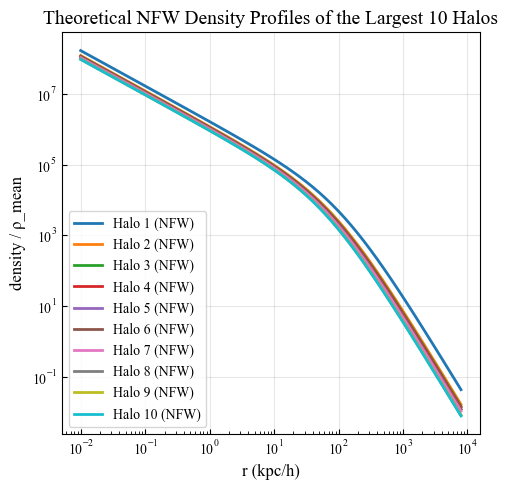

In [9]:
# Create an NFW density profile for each halo
profiles = []
for i in range(len(top10_halo_ids)):
    Mvir = halo_masses[i]
    cvir = 5.0  # Assumed concentration
    z = 0.0
    p_nfw = profile_nfw.NFWProfile(M=Mvir, c=cvir, z=z, mdef='vir')
    profiles.append(p_nfw)

# Calculate and plot the density profiles
r = 10**np.arange(-2, 4, 0.1)  # Radius range
plt.figure(figsize=(5, 5))

for i, p in enumerate(profiles):
    rho_nfw = p.density(r)
    plt.plot(r, rho_nfw / cosmo.rho_m(0), label=f'Halo {i+1} (NFW)', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (kpc/h)', fontsize=12)
plt.ylabel('density / ρ_mean', fontsize=12)
plt.tick_params(direction='in', which='both')
plt.title('Theoretical NFW Density Profiles of the Largest 10 Halos', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
def diagnose_coordinates_and_center(halo_coords, center, halo_id):
    """Diagnose coordinate and center issues"""
    print(f"\nHalo {halo_id} coordinate diagnosis:")
    print(f"  Particle coordinate ranges:")
    print(f"    X: {np.min(halo_coords[:, 0]):.3f} - {np.max(halo_coords[:, 0]):.3f}")
    print(f"    Y: {np.min(halo_coords[:, 1]):.3f} - {np.max(halo_coords[:, 1]):.3f}")
    print(f"    Z: {np.min(halo_coords[:, 2]):.3f} - {np.max(halo_coords[:, 2]):.3f}")
    print(f"  Halo center: [{center[0]:.3f}, {center[1]:.3f}, {center[2]:.3f}]")
    
    # Calculate distance statistics
    distances = np.sqrt(np.sum((halo_coords - center)**2, axis=1))
    print(f"  Distance statistics:")
    print(f"    Minimum distance: {np.min(distances):.6f}")
    print(f"    Maximum distance: {np.max(distances):.6f}")
    print(f"    Average distance: {np.mean(distances):.6f}")
    print(f"    Median distance: {np.median(distances):.6f}")
    print(f"    90th percentile: {np.percentile(distances, 90):.6f}")
    
    return distances

In [11]:
def recalculate_halo_center(halo_coords, method='mean'):
    """Recalculate halo center using different methods"""
    if method == 'mean':
        return np.mean(halo_coords, axis=0)
    elif method == 'median':
        return np.median(halo_coords, axis=0)
    elif method == 'density_peak':
        # Find the region with highest particle density
        # Use the center of mass of the innermost 1% of particles
        center_rough = np.mean(halo_coords, axis=0)
        distances = np.sqrt(np.sum((halo_coords - center_rough)**2, axis=1))
        n_inner = max(1, len(halo_coords) // 100)  # Take 1% of particles
        inner_indices = np.argsort(distances)[:n_inner]
        return np.mean(halo_coords[inner_indices], axis=0)

In [12]:
def calculate_radial_density_profile_improved(halo_coords, center, particle_mass,
                                            coordinate_unit_factor=1.0, n_bins=15):
    """Improved radial density profile calculation with unit conversion"""
    # Apply coordinate unit conversion factor
    halo_coords_corrected = halo_coords * coordinate_unit_factor
    center_corrected = center * coordinate_unit_factor
    
    # Calculate particle distances from halo center
    distances = np.sqrt(np.sum((halo_coords_corrected - center_corrected)**2, axis=1))
    
    # Remove particles with zero distance
    distances = distances[distances > 0]
    
    if len(distances) == 0:
        return np.array([]), np.array([])
    
    # Use actual distance range
    r_min = np.min(distances) * 0.9
    r_max = np.max(distances) * 1.1
    
    # Logarithmically spaced bins
    r_bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins+1)
    r_centers = np.sqrt(r_bins[:-1] * r_bins[1:])
    
    # Calculate density in each bin
    densities = []
    
    for i in range(n_bins):
        mask = (distances >= r_bins[i]) & (distances < r_bins[i+1])
        n_particles = np.sum(mask)
        
        shell_volume = (4.0/3.0) * np.pi * (r_bins[i+1]**3 - r_bins[i]**3)
        
        if shell_volume > 0 and n_particles > 0:
            density = (n_particles * particle_mass) / shell_volume
        else:
            density = np.nan
        
        densities.append(density)
    
    densities = np.array(densities)
    valid_idx = ~np.isnan(densities) & (densities > 0)
    
    return r_centers[valid_idx], densities[valid_idx]

In [13]:
def calculate_concentration(halo_mass, z=0.0):
    """Calculate concentration parameter based on halo mass"""
    # Using Duffy et al. (2008) relation
    A = 5.71
    B = -0.084
    C = -0.47
    M_pivot = 2e12  # h^-1 M_sun
    
    c = A * (halo_mass / M_pivot)**B * (1 + z)**C
    return c

In [14]:
coordinate_unit_factors = [1.0, 1000.0, 2000.0]  # Test different possible units
print("Starting unit diagnosis...")

Starting unit diagnosis...


In [15]:
# Analyze only the first 3 halos for diagnosis
for halo_idx in range(min(3, len(halo_masses))):
    print(f"\n" + "="*50)
    print(f"Diagnosing Halo {halo_idx + 1}")
    print(f"="*50)
    
    particle_indices = np.where(group_ids == top10_halo_ids[halo_idx])[0]
    halo_coords = coordinates[particle_indices]
    original_center = halo_centers[halo_idx]
    
    # Basic diagnosis
    distances_orig = diagnose_coordinates_and_center(halo_coords, original_center, halo_idx + 1)
    
    # Test different center calculation methods
    print(f"\n  Testing different center calculation methods:")
    center_mean = recalculate_halo_center(halo_coords, 'mean')
    center_median = recalculate_halo_center(halo_coords, 'median')
    center_density = recalculate_halo_center(halo_coords, 'density_peak')
    
    print(f"    Original center: [{original_center[0]:.3f}, {original_center[1]:.3f}, {original_center[2]:.3f}]")
    print(f"    Mean center: [{center_mean[0]:.3f}, {center_mean[1]:.3f}, {center_mean[2]:.3f}]")
    print(f"    Median center: [{center_median[0]:.3f}, {center_median[1]:.3f}, {center_median[2]:.3f}]")
    print(f"    Density peak center: [{center_density[0]:.3f}, {center_density[1]:.3f}, {center_density[2]:.3f}]")
    
    # Test different coordinate units
    print(f"\n  Testing different coordinate unit conversion factors:")
    for factor in coordinate_unit_factors:
        distances_test = np.sqrt(np.sum((halo_coords * factor - original_center * factor)**2, axis=1))
        print(f"    Unit factor {factor}: distance range {np.min(distances_test):.2f} - {np.max(distances_test):.2f}")
        
        # Estimate virial radius to check reasonableness
        Rvir = mass_so.M_to_R(halo_masses[halo_idx], 0.0, 'vir')
        print(f"    Theoretical Rvir: {Rvir:.2f} kpc/h")
        print(f"    Max distance/Rvir: {np.max(distances_test)/Rvir:.3f}")


Diagnosing Halo 1

Halo 1 coordinate diagnosis:
  Particle coordinate ranges:
    X: 41.385 - 41.743
    Y: 48.508 - 48.782
    Z: 1.552 - 1.792
  Halo center: [41.596, 48.644, 1.670]
  Distance statistics:
    Minimum distance: 0.000682
    Maximum distance: 0.214823
    Average distance: 0.067662
    Median distance: 0.064671
    90th percentile: 0.115035

  Testing different center calculation methods:
    Original center: [41.596, 48.644, 1.670]
    Mean center: [41.596, 48.644, 1.670]
    Median center: [41.597, 48.645, 1.671]
    Density peak center: [41.596, 48.645, 1.671]

  Testing different coordinate unit conversion factors:
    Unit factor 1.0: distance range 0.00 - 0.21
    Theoretical Rvir: 578.53 kpc/h
    Max distance/Rvir: 0.000
    Unit factor 1000.0: distance range 0.68 - 214.82
    Theoretical Rvir: 578.53 kpc/h
    Max distance/Rvir: 0.371
    Unit factor 2000.0: distance range 1.36 - 429.65
    Theoretical Rvir: 578.53 kpc/h
    Max distance/Rvir: 0.743

Diagnosi

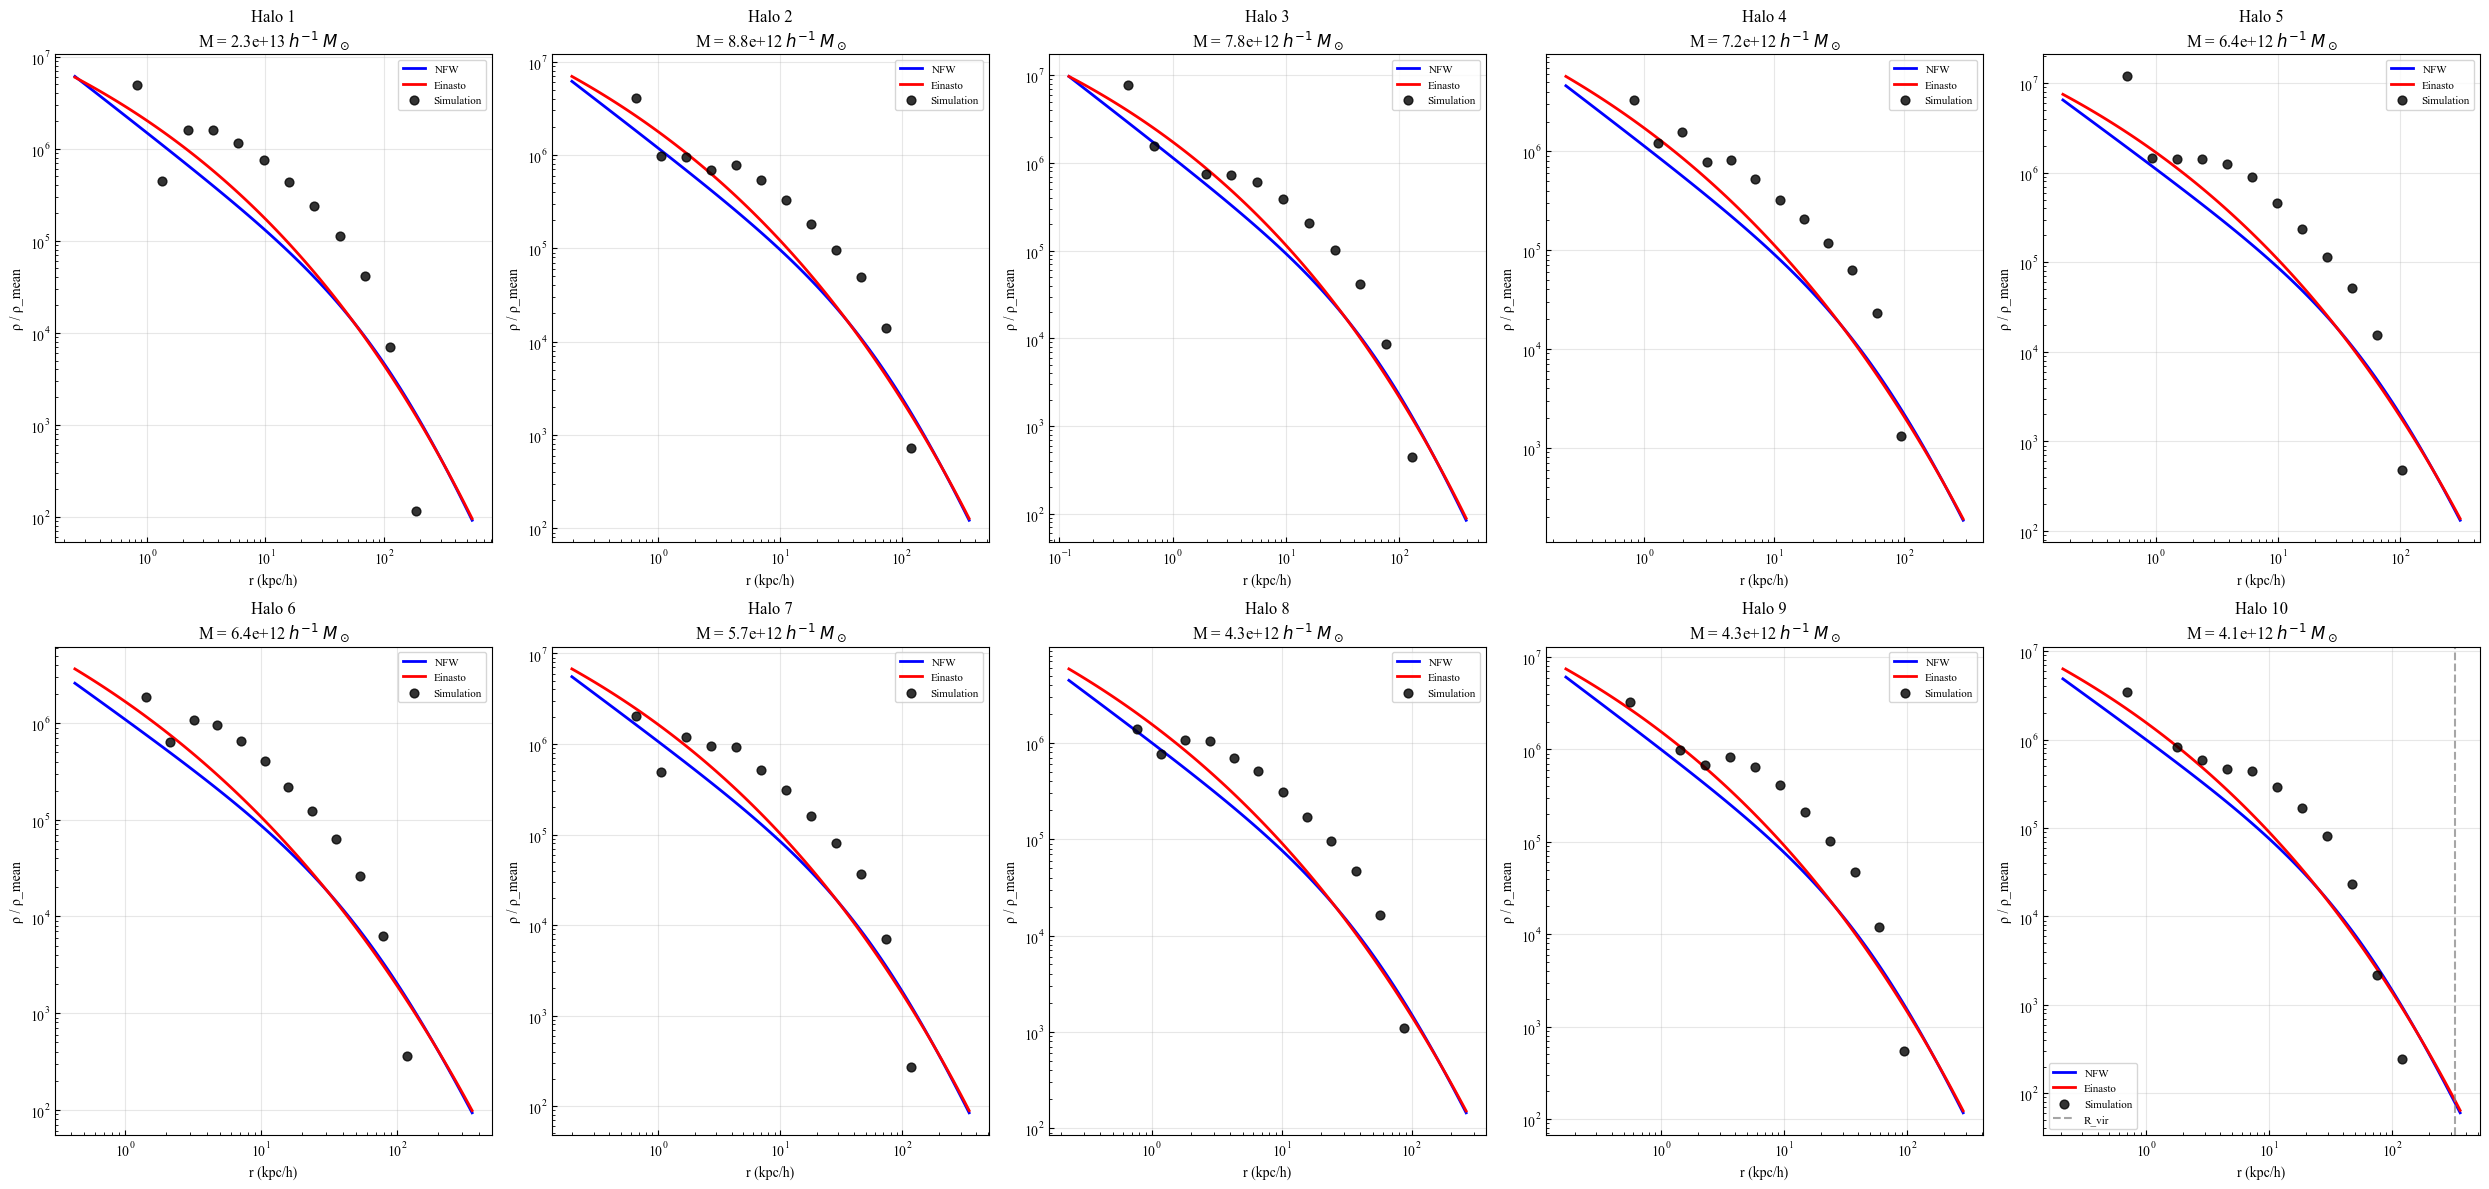

In [16]:
# Choose the most appropriate parameters based on diagnosis results
# Usually if max distance/Rvir is close to 1-3, the unit conversion is correct
coordinate_unit_factor = 1000.0  # Adjust this value based on your diagnosis results

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 12))

for i, ax in enumerate(axes.flat):
    if i < len(halo_masses):
        halo_mass = halo_masses[i]
        
        # Get particles
        particle_indices = np.where(group_ids == top10_halo_ids[i])[0]
        halo_coords = coordinates[particle_indices]
        
        # Recalculate center (using density peak method)
        center = recalculate_halo_center(halo_coords, 'density_peak')
        
        # Calculate corrected radial density profile
        r_sim, rho_sim = calculate_radial_density_profile_improved(
            halo_coords, center, particle_mass,
            coordinate_unit_factor=coordinate_unit_factor, n_bins=12
        )
        
        if len(r_sim) == 0:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Halo {i+1}')
            continue
        
        # Calculate theoretical profiles
        Rvir = mass_so.M_to_R(halo_mass, 0.0, 'vir')
        c_est = calculate_concentration(halo_mass, 0.0)
        
        r_start = np.min(r_sim) * 0.3
        r_end = np.max(r_sim) * 3.0
        r_theory = np.logspace(np.log10(r_start), np.log10(r_end), 100)
        
        try:
            nfw_profile = profile_nfw.NFWProfile(M=halo_mass, c=c_est, z=0.0, mdef='vir')
            einasto_profile = profile_einasto.EinastoProfile(M=halo_mass, c=c_est, z=0.0, mdef='vir')
            
            rho_nfw = nfw_profile.density(r_theory)
            rho_einasto = einasto_profile.density(r_theory)
            rho_mean = cosmo.rho_m(0.0)
            
            ax.plot(r_theory, rho_nfw / rho_mean, label=f'NFW',
                   color='blue', linestyle='-', linewidth=2)
            ax.plot(r_theory, rho_einasto / rho_mean, label=f'Einasto',
                   color='red', linestyle='-', linewidth=2)
            
        except Exception as e:
            print(f"  Error creating theoretical profiles for halo {i+1}: {e}")
        
        # Plot simulation data
        ax.scatter(r_sim, rho_sim / rho_mean,
                  label='Simulation', color='black', s=40, alpha=0.8, zorder=5)
        
        # Add virial radius line
        if r_start <= Rvir <= r_end:
            ax.axvline(Rvir, color='gray', linestyle='--', alpha=0.7, label=f'R_vir')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('r (kpc/h)')
        ax.set_ylabel('ρ / ρ_mean')
        # ax.set_title(f'Halo {i+1} \nM={halo_mass:.1e} $h^{-1}$ $M_\odot$')
        # ax.set_title(rf'Halo {i+1} \n M = {halo_mass:.1e} $h^{{-1}}$ $M_\odot$')
        title_lines = [f'Halo {i+1}', 
               rf'M = {halo_mass:.1e} $h^{{-1}}$ $M_\odot$']
        ax.set_title('\n'.join(title_lines))
        ax.tick_params(direction='in', which='both')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()